In [ ]:
import pandas as pd
import numpy as np
from __future__ import print_function, division
import sklearn.svm as svm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
digits = load_digits()
print(digits.data)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


<Figure size 640x480 with 0 Axes>

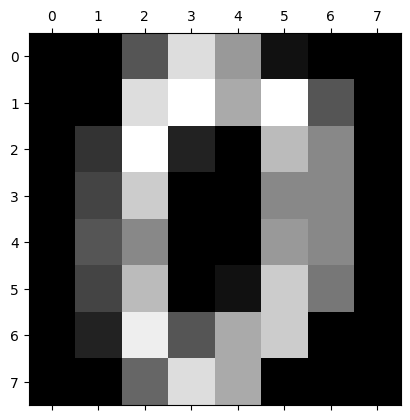

In [ ]:
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [ ]:
clf = svm.SVC(gamma=0.001, C=100.)
# split the data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=2017)
# fit the classifier with train data
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.98      1.00      0.99        41
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        32
           5       1.00      0.98      0.99        46
           6       1.00      1.00      1.00        29
           7       1.00      1.00      1.00        42
           8       1.00      0.97      0.99        35
           9       0.97      1.00      0.98        30

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

0.9944444444444445


применяю модель svm.SVC с параметрами gamma=0.001, C=100.
Скор высокий 0,99
Гиперпараметр  используется для настройки чувствительности к различиям в векторах признаков, которая, в свою очередь, зависит от различных вещей, таких как размерность входного пространства и нормализация признаков.
Если увеличивать до gamma=0.01
Скор будет падать


In [ ]:
param_grid = {'C': [1, 10, 100, 1000]}
grid = GridSearchCV(LinearSVC(dual=False, max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.94
Best parameters:  {'C': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Теперь попробуем использовать GridSearchCV с Pipeline .
Создаем конвейер, который выполняет уменьшение размерности с последующим
прогнозированием с помощью классификатора опорных векторов.
Создаем Pipeline используя LinearSVC




In [ ]:

pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ('reduce_dim', PCA()),
    ('classify', LinearSVC(dual=False, max_iter=1000))
])

Параметры GridSearchCV:
param_grid — передаем какие параметры хотим подбирать

cv — сколько разрезов кросс-валидации мы ходим сделать; =3

In [ ]:
N_FEATURES_OPTIONS = [2,4,8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

In [ ]:
grid = GridSearchCV(pipe, cv=3, n_jobs=2, param_grid=param_grid)
grid.fit(digits.data, digits.target)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaling', MinMaxScaler()),
                                       ('reduce_dim', PCA()),
                                       ('classify', LinearSVC(dual=False))]),
             n_jobs=2,
             param_grid=[{'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [PCA(iterated_power=7, n_components=8),
                                         NMF()],
                          'reduce_dim__n_components': [2, 4, 8]},
                         {'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [SelectKBest(score_func=<function chi2 at 0x7e25e2793400>)],
                          'reduce_dim__k': [2, 4, 8]}])

In [ ]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores

array([0.52031163, 0.74791319, 0.85698386, 0.30383973, 0.63995548,
       0.79966611, 0.52309405, 0.74902615, 0.8558709 , 0.31552588,
       0.65386756, 0.8196995 , 0.52309405, 0.74846967, 0.85308848,
       0.31608236, 0.64997218, 0.82415136, 0.52309405, 0.74846967,
       0.85308848, 0.31719533, 0.64774624, 0.82192543, 0.32721202,
       0.5180857 , 0.70617696, 0.32888147, 0.52698943, 0.71229827,
       0.32888147, 0.52587646, 0.71062883, 0.32888147, 0.52587646,
       0.71007234])

In [ ]:
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
mean_scores

array([[[0.52031163, 0.74791319, 0.85698386],
        [0.30383973, 0.63995548, 0.79966611],
        [0.52309405, 0.74902615, 0.8558709 ]],

       [[0.31552588, 0.65386756, 0.8196995 ],
        [0.52309405, 0.74846967, 0.85308848],
        [0.31608236, 0.64997218, 0.82415136]],

       [[0.52309405, 0.74846967, 0.85308848],
        [0.31719533, 0.64774624, 0.82192543],
        [0.32721202, 0.5180857 , 0.70617696]],

       [[0.32888147, 0.52698943, 0.71229827],
        [0.32888147, 0.52587646, 0.71062883],
        [0.32888147, 0.52587646, 0.71007234]]])

Выбираем лучшие средние скоры

In [ ]:
mean_scores = mean_scores.max(axis=0)
mean_scores

array([[0.52309405, 0.74846967, 0.85698386],
       [0.52309405, 0.74846967, 0.85308848],
       [0.52309405, 0.74902615, 0.8558709 ]])

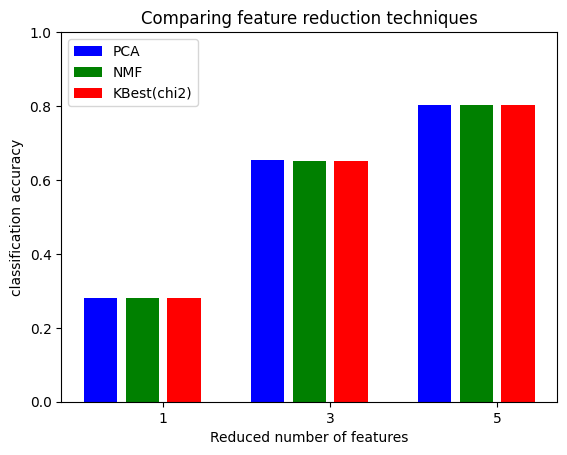

In [ ]:
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()

Видно что с уменьшением количества выбраных фич точность классификации будет снижаться